## Setup

We assume there are $N$ competing firms, which we will call *players*. Similarly we have $M$ groups that form different subpopulations, such that $\mathcal{D}_j$ is the distribution of users in group $j$. Let $\beta_j$ be the probability that a randomly selected member of the whole polulation belongs to  group $j$.

We instantiate the following sequential game:

- At time $t$: $\alpha^t_j \in \Delta^{N}$ is the allocation vector such that $\alpha_{ij}^t$ is the fraction of group $j$ allocated to player $i$ at time $t$.

- Player $i$ observes a distribution of users: $\mathbb{D}_i^t \propto \sum_{j=1}^M \beta_j \alpha_{ij}^t \mathcal{D}_j$. The player thus captures $\sum_{j=1}^M \beta_j \alpha_{ij}^t$ fraction of the market share. The utility of the player will henceforth assumed to be the total participation. (We can make further assumptions about whether the player knows the allocations of each group or knows the group memberships).

- Player $i$ sets a decision rule parametrized by $\theta_i^t$. One way to do that is to assume that the player perform loss minimization. At the population level this would be:
\begin{align}
\theta_i^t &= \arg\min_{\theta} \mathbb{E}_{x\sim \mathbb{D}_i^t}[\ell(x, \theta)]\\
&=\arg \min_{\theta}\sum_{j=1}^M \beta_j\alpha^t_{ij} r_j(\theta)
\end{align}
where $r_j(\theta) = \mathbb{E}_{x\sim \mathcal{D}_j}[\ell(x, \theta)]$ and $\ell$ is some loss function.

If we make the assumption that the average risk experienced bu group $j$ is $r_j(\theta) = \Vert \theta - \theta_j^*\Vert_2^2 +1$, where $\theta_j^*$ is the optimal decision for group $j$. 

- Each group experiences total risk: $R^t_j = \sum_{i=1}^N \alpha_{ij}^t r_j(\theta^t_i)$. Based on the risk from each player, the group updates the allocations to $\alpha_j^{t+1}$.
  - We will make `statefull` assumptions for which we will study MWU dynamics of the form:

Here we will study the stateful assumption where the weights update as:
$$\alpha_{ij}^{t+1} \propto \alpha_{ij}^t(1-\epsilon)^{c_j(r_j(\theta_i^t))} $$
where $c_j$ is some sensible choice of comparison function, in experiments we will use the identity.

#### Questions
- What are the resulting dynamics:
    - For various choices of population (size, population optimal loss, initial allocations, etc)

## Import Statements

In [5]:
# Plotting settings
from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import cvxpy as cvx
from numpy.random.mtrand import beta
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize

from scipy.optimize import brent
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

In [6]:
rc('text', usetex = False)
rc('font', family = 'serif')
TITLE_SIZE = 13
LABEL_SIZE = 11
LEGEND_TITLE_SIZE = 12
LEGEND_SIZE = 11
TICK_SIZE = 11
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
params["font.family"] = "Times New Roman"
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=FONT)

## Defining subpopulation class and player dynamics

In [101]:
""" Subpopulations """

class SubPop():
    def __init__(self, theta_star, beta, alphas, cov=None, sigmasq=1):
        """ Subpopulation Class

        Args:
            theta_star (np.array): optimal decision rule for the sub-population
            beta (float): Size of the subpopulation (absolute or relative)
            alphas (np.array): Allocation of the sub-population to different firms
                                must sum up to 1
            cov (2d np.array, optional): Covariance matrix. Defaults to None.
            sigmasq (float. optional): Risk offset. Defaults to 1.
        """ 
        self.theta_star = theta_star
        self.d = theta_star.size
        self.cov = np.eye(self.d) if cov is None else cov
        self.sigmasq = sigmasq
        self.beta = beta
        self.alphas = alphas
        self.t = 0
        self.converged = False
        self.converged_for = 0

    def min_expr(self, i):
        # used by the i-th player
        A = self.beta * self.alphas[i] * self.cov
        b = self.beta * self.alphas[i] * np.dot(self.cov, self.theta_star)
        return A, b
    
    def update_alpha(self, thetas, epsilon=0.1,):
        r = [self.risk(theta) for theta in thetas]
        new_alphas = self.alphas * np.power((1-epsilon), r)
        new_alphas /= np.sum(new_alphas)
        self.converged = np.allclose(new_alphas, self.alphas)
        if self.converged:
            self.converged_for += 1
        self.alphas = new_alphas
        self.t += 1 

    def break_player(self, i):
        # break player i into 2 players, add clone of i to the end
        alphas = self.alphas
        alphas[i] = self.alphas[i]/2
        self.alphas = np.append(alphas, alphas[i])
        self.converged = False
        self.converged_for = 0

    def risk(self, theta):
        return(np.linalg.norm(np.dot(self.cov, theta - self.theta_star))**2 + self.sigmasq)

class QuadraticSubPop(SubPop):
    def __init__(self, *args, **kwargs):
        super(QuadraticSubPop, self).__init__(*args, **kwargs)
        self.kind = 'quadratic'


class EmpiricalSubPop(SubPop):
    def __init__(self, *args,  N=100, **kwargs):
        super(EmpiricalSubPop, self).__init__(*args, **kwargs)
        self.N = N
        self.kind = 'empirical'
        self.make_data()
        self.theta_star_emp = np.dot(np.linalg.pinv(self.xs), self.ys).flatten()


    def make_data(self):
        self.xs = np.random.multivariate_normal(np.zeros(self.d), self.cov, size=self.N)
        self.ys = np.array([np.dot(self.theta_star, x)+
                       np.random.normal(0, scale=np.sqrt(self.sigmasq)) for x in self.xs])

    def min_expr(self, i):
        A = self.beta*self.alphas[i] * self.xs
        b = self.beta*self.alphas[i] * self.ys
        return A, b
    
    def risk(self, theta):
        return np.linalg.norm(self.xs @ theta - self.ys)**2/self.N

In [102]:
def quadratic_min(subpops, i):
    b_list = []
    A_list = []
    for subpop in subpops:
        A, b = subpop.min_expr(i)
        A_list.append(A); b_list.append(b)
    A = np.sum(A_list, axis=0)
    b = np.sum(b_list, axis=0)
    return np.dot(np.linalg.pinv(A), b).flatten()

def noisy_quadratic_min(subpops, i):
    noiseless_theta = quadratic_min(subpops, i)
    var = np.var(noiseless_theta)
    noise = np.random.normal(size=noiseless_theta.shape, scale=0.0001*var)
    return noise+noiseless_theta

def player_decisions(subpops, current = None, min_fn=quadratic_min):
    '''alpha[i,j] <- fraction of group j allocated to player i'''
    n_players = len(subpops[0].alphas)
    n_groups = len(subpops)
    new_thetas = []
    for i in range(n_players):
        if current is None or current == i:
            theta_i = min_fn(subpops, i)
            new_thetas.append(theta_i)
    return new_thetas

def get_all_risks(thetas, subpops, weighted_alpha=True, weighted_beta=True):
    n_players = len(thetas)
    n_groups = len(subpops)
    r = np.zeros((n_players, n_groups))
    for i in range(n_players):
        for j in range(n_groups):
            r[i,j] = subpops[j].risk(thetas[i])
            if weighted_alpha:
                r[i,j] *= subpops[j].alphas[i]
            if weighted_beta:
                r[i,j] *= subpops[j].beta
    return r

def group_decisions(thetas, subpops, epsilon = 0.1):
    [subpop.update_alpha(thetas, epsilon) for subpop in subpops]
    return np.array([subpop.alphas for subpop in subpops])

def average_risk_group(thetas, subpops):
    r = get_all_risks(thetas, subpops, weighted_alpha=True)
    return np.sum(r, 0)

def average_risk_player(thetas, subpops):
    r = get_all_risks(thetas, subpops, weighted_alpha=True, weighted_beta=True)
    return np.sum(r, 1)

def player_share(subpops):
    n_players = len(subpops[0].alphas)
    return [np.sum([s.alphas[i]*s.beta for s in subpops]) for i in range(n_players)]

def convergent_count(subpops):
    c_counts = [subpop.converged_for for subpop in subpops]
    return c_counts


## Dynamics Simulation

In [103]:
def run_experiment(T, subpops, rr=False, min_fn=quadratic_min, early_stop=False, verbose = True):
    n_players = len(subpops[0].alphas)
    if verbose:
        print("Initial Conditions:")
        print(f"There are {n_players} initial players")
        print(f"Group splits: {[s.beta for s in subpops]}")
        print(f"Initial allocations: {[s.alphas for s in subpops]}")
        print(f"Optimal decisions theta for each group (row-wise) {[s.theta_star for s in subpops]}")
    average_risks_group = []
    average_risks_player = []
    all_risks = []
    all_thetas = []
    all_alphas = []
    for t in range(T):
        if rr and t>0:
            player = t%n_players
            theta_player = np.array(player_decisions(subpops, current=player))
            thetas[player] = theta_player
            thetas = copy.deepcopy(thetas)
            all_thetas.append(thetas)
        else:
            thetas = np.array(player_decisions(subpops,  min_fn=min_fn))
        alpha = group_decisions(thetas, subpops)
        all_thetas.append(thetas)
        all_alphas.append(alpha.T)
        risks = get_all_risks(thetas, subpops)
        all_risks.append(risks)
        a_risk_group = average_risk_group(thetas, subpops)
        average_risks_group.append(a_risk_group)
        a_risk_player = average_risk_player(thetas, subpops)
        average_risks_player.append(a_risk_player)
        if early_stop:
            c_counts = convergent_count(subpops)
            if min(c_counts) > 20:
                break
    if verbose:
        print("Final Conditions:")
        print(f'\t\tPlayers decisions: {thetas}')
        print(f'\t\tGroup allocations: {alpha}')
    return(average_risks_group, average_risks_player, all_risks, all_thetas, all_alphas) 

## Figure 1: Risk profiles over time

In [104]:
def plot_experiment(average_risks_group, average_risks_player, all_risks, all_thetas, all_alphas):
    
    n_players, n_groups = all_risks.shape
    n_cols = max(n_players, n_groups)+1
    fig, ax = plt.subplots(2, n_cols, figsize = (6*n_cols,12))
    # Group allocation
    for group in range(n_groups):
        print(n_players)
        for player in range(n_players):
            ax[0,group].plot([a[player,group] for a in all_alphas], label = f"% allocated to Player {player + 1}")
            ax[0,group].set_xlabel('Timestep (t)')
            ax[0,group].set_ylabel('% group')
            ax[0,group].set_title(f'Group {group+1}')
            ax[0,group].legend()

        # Average Losses of the groups
        ax[0,n_cols-1].plot([a[group] for a in average_risks_group], label = f"Group {group + 1}")
        ax[0,n_cols-1].set_xlabel('Timestep (t)')
        ax[0,n_cols-1].set_ylabel('Risk')
        ax[0,n_cols-1].set_title('Average Group risk over time')
        ax[0,n_cols-1].legend()

    # Player portfolio
    for player in range(n_players):     
        for group in range(n_groups):
            ax[1,player].plot([a[player,group] for a in all_alphas], label = f"% of group {group + 1} currently allocated")
            ax[1,player].set_xlabel('Timestep (t)')
            ax[1,player].set_ylabel('% player')
            ax[1,player].set_title(f'Player {player+1}')
            ax[1,player].legend()
           
        # Player Utilities (Market Share)
        ax[1,n_cols-1].plot([a[player] for a in average_risks_player], label = f"Player {player + 1}")
        ax[1,n_cols-1].set_xlabel('Timestep (t)')
        ax[1,n_cols-1].set_ylabel('Risk')
        ax[1,n_cols-1].set_title('Average player risk over time')
        ax[1,n_cols-1].legend()
    
    # Remove unnecesary axis:
    if n_players > n_groups:
        for group in range(n_groups, n_players):
            ax[0, group].set_axis_off()
    if n_groups > n_players:
        for player in range(n_players, n_groups):
            ax[1, player].set_axis_off()
    plt.show()
    

In [105]:
def plot_short_experiment(average_risks_group, average_risks_player, all_risks, axs, ls= '-', lw=2, legend = False):
    
    n_players, n_groups = all_risks[0].shape
    c = ['tab:blue', 'tab:orange', 'tab:green']
    for group in range(n_groups-2):
        # Average Losses of the groups
        axs[0].plot([a[group] for a in average_risks_group], color = c[group], ls= ls, lw=lw,label = f"Subpop {group + 1}")
        axs[0].set_xlabel('Time t')
        axs[0].set_ylabel('Risk')
        axs[0].set_title('Average Subpopulation risk over time')
        if legend:
            axs[0].legend()


    for player in range(n_players-1):     
        # Player Risks
        player = player-1
        axs[1].plot([a[player] for a in average_risks_player], color = c[player], ls= ls, lw=lw , label = f"Learner {player + 1}")
        axs[1].set_xlabel('Time t')
        axs[1].set_ylabel('Risk')
        axs[1].set_title('Average Learner risk over time')
        if legend:
            axs[1].legend()
    
    total_risk = [np.sum(round_risks) for round_risks in all_risks]
    axs[2].plot(total_risk, ls= ls, lw=lw+1, c = 'k')
    axs[2].set_xlabel('Time t')
    axs[2].set_ylabel('Risk')
    axs[2].set_title('Total risk over time')
    #axs[1].legend()
    

In [106]:
def run_trial(allocation=None):
    T = 500
    # relative sizes
    beta_1 = 1
    beta_2 = 1 
    beta_3 = 1
    # beta = np.array([beta_1, beta_2])
    # initial allocations
    dist = np.array([[0.01, 0.02, -0.04], [-0.01,-0.01, 0.02]])
    dist = np.random.rand(2,3)*0.1
    alpha = np.array([[1,1, 1], [1,1, 1]]) + dist
    # alpha_ij <- fraction of group j going to firm i
    alpha =  normalize(alpha, axis=0, norm='l1')
    if allocation is not None:
        alpha = allocation
    print(alpha)
    # optimal thetas for each group
    theta_star_1 = np.array([0, 1])
    theta_star_2 = np.array([1, 1])
    theta_star_3 = np.array([0.6, 0])
    # theta_star = np.array([theta_star_1, theta_star_2])

    pop1 = QuadraticSubPop(theta_star_1, beta_1, alpha[:,0])
    pop2 = QuadraticSubPop(theta_star_2, beta_2, alpha[:,1])
    pop3 = QuadraticSubPop(theta_star_3, beta_3, alpha[:,2])
    subpops = [pop1, pop2, pop3]

    # Run dynamics and create plots
    (average_risks_group, average_risks_player, all_risks, all_thetas, all_alphas) = run_experiment(T, subpops, min_fn=noisy_quadratic_min, rr=False)
    
    return(average_risks_group, average_risks_player, all_risks)


[[0.5 0.5 0.5]
 [0.5 0.5 0.5]]
Initial Conditions:
There are 2 initial players
Group splits: [1, 1, 1]
Initial allocations: [array([0.5, 0.5]), array([0.5, 0.5]), array([0.5, 0.5])]
Optimal decisions theta for each group (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Players decisions: [[0.5 1. ]
 [0.6 0. ]]
		Group allocations: [[1. 0.]
 [1. 0.]
 [0. 1.]]
[[0.496 0.511 0.498]
 [0.504 0.489 0.502]]
Initial Conditions:
There are 2 initial players
Group splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each group (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Players decisions: [[1.  1. ]
 [0.3 0.5]]
		Group allocations: [[0. 1.]
 [1. 0.]
 [0. 1.]]
[[0.501 0.491 0.494]
 [0.499 0.509 0.506]]
Initial Conditions:
There are 2 initial players
Group splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([

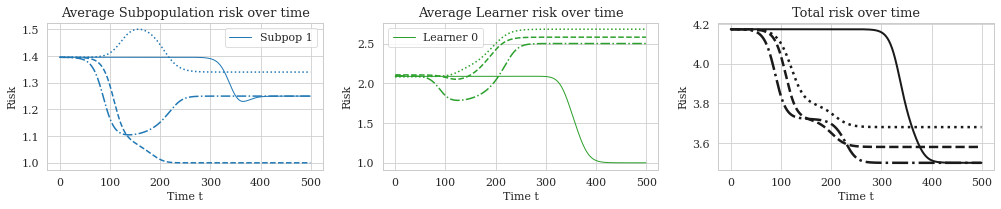

In [107]:
allocations = [np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               ]
with context:
    fig, axs = plt.subplots(1,3, figsize = (14,3))
    for t in range(4):
        (average_risks_group, average_risks_player, all_risks) = run_trial(allocations[t])
        if t >0:
            lw = 1.5
            if t == 1:
                ls = ':'
            if t == 2:
                ls = '--'
            if t ==3:
                ls = '-.'
            legend = False
        else: 
            lw = 1
            ls = '-'
            legend = True
        plot_short_experiment(average_risks_group, average_risks_player, all_risks, axs, ls=ls, lw = lw, legend=legend)
    plt.tight_layout()
fig.savefig('risk_dynamics.pdf')

## Increased competition experiments

In [75]:
def run_competition_experiment(T, subpops, n_players_max=None, min_fn=noisy_quadratic_min):
    n_players_init = len(subpops[0].alphas)
    if n_players_max is None:
        n_players_max = len(subpops)
    print("Initial Conditions:")
    print(f"There are {n_players_init} initial players")
    exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)
    average_risks_group, average_risks_player, all_risks, all_thetas, all_alphas = exp_out
    total_average_risks_group_over_time = {-1: average_risks_group}
    for i in range(n_players_max - n_players_init):
        print(i)
        for subpop in subpops:
            subpop.break_player(i)
        exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)  
        total_average_risks_group_over_time[i] = exp_out[0]
    return(total_average_risks_group_over_time)

In [167]:
seed = 10
rng = np.random.default_rng(seed)
T = 1000
n_groups = 50
n_players_init = 2
d = 8
# relative sizes
beta = 1
# initial allocations
dist = rng.random(size=(n_players_init,n_groups))*0.0001
alpha = np.ones(shape=(n_players_init,n_groups)) + dist
# alpha_ij <- fraction of group j going to firm i
alpha =  normalize(alpha, axis=0, norm='l1')

# optimal thetas for each group
theta_star = rng.normal(size=(n_groups, d))
subpops = [QuadraticSubPop(theta_star[i,:], beta, alpha[:,i]) for i in range(n_groups)]

In [168]:
res = run_competition_experiment(T, subpops, n_players_max=None, min_fn=noisy_quadratic_min)

Initial Conditions:
There are 2 initial players
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [221]:
average_res= {k:np.mean(np.array(v), 1) for k, v in res.items()}
group_equilibrium_res = {k:v[-1] for k, v in res.items()}
average_equilibrium_res= {k:v[0] for k, v in average_res.items()}
break_times = {k:len(v) for k, v in average_res.items()}
break_times = np.cumsum(list(break_times.values()))

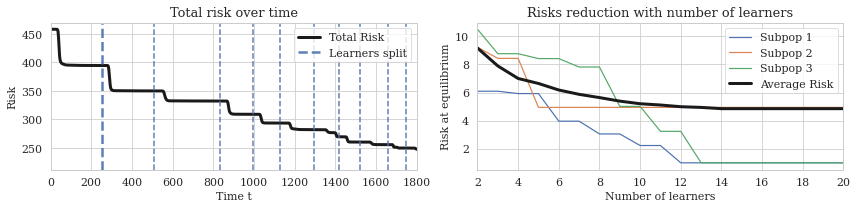

In [242]:
with context:
    fig, axs = plt.subplots(1,2, figsize = (12,3))
    axs[0].plot(n_groups*np.concatenate((list(average_res.values()))), c='k', lw =3, label = 'Total Risk')
    for i, bt in enumerate(break_times):
        if i == 0:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 2.5, label='Learners split')
        else:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 1.5)
    axs[0].legend(loc = 1)
    axs[0].set_xlim([0, 1800])
    eq_risks = np.array(list(group_equilibrium_res.values()))
    axs[1].plot(range(n_players_init, n_players_init+len(eq_risks)), eq_risks[:,[1,2,3]], label ='Subpop')
    axs[1].plot(range(n_players_init, n_players_init+len(eq_risks)), 
                list(average_equilibrium_res.values()), c='k', lw =3, label = 'Average Risk')
    axs[1].legend()
    axs[1].set_xlim([2, 20])
    axs[0].set_xlabel('Time t')
    axs[1].set_xlabel('Number of learners')
    axs[0].set_ylabel('Risk')
    axs[1].set_ylabel('Risk at equilibrium')
    axs[0].set_title('Total risk over time')
    axs[1].set_title('Risks reduction with number of learners')
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h, ['Subpop 1', 'Subpop 2', 'Subpop 3', 'Average Risk'])
    plt.tight_layout()
    fig.savefig('competition.pdf')

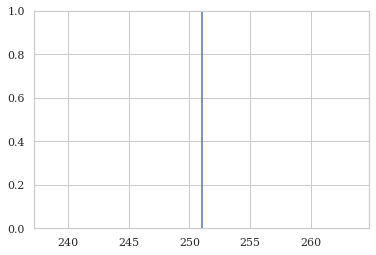

In [223]:
plt.axvline(x=break_times[0])

In [176]:
len(a[])

8

In [220]:
np.cumsum(list(break_times.values()))

array([ 251,  509,  831,  995, 1129, 1293, 1420, 1522, 1658, 1748, 1845,
       1912, 1933, 1954, 1975, 1996, 2017, 2038, 2059, 2080, 2287, 2308,
       2329, 2350, 2371, 2392, 2413, 2434, 2455, 2522, 2543, 2564, 2585,
       2606, 2627, 2648, 2669, 2690, 2711, 2732, 2753, 2845, 2866, 2887,
       2908, 2929, 2950, 2971, 2992])